# Functionalizing the SINDy-SHRED pipeline

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**. 

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **weekly mean sea-surface temperature (SST) dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe the SST evolution.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import copy
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from scipy.integrate import solve_ivp

import sindy_shred

warnings.filterwarnings("ignore")

In [2]:
def relative_error(x_est, x_true):
    """Helper function for calculating the relative error.

    :param x_est: Estimated values (i.e. from reconstruction)
    :type x_est: numpy.ndarray
    :param x_true: True (or observed) values.
    :type x_true: numpy.ndarray
    :return: Relative error between observations and model.
    :rtype: numpy.ndarray
    """
    return np.linalg.norm(x_est - x_true) / np.linalg.norm(x_true)

In [3]:
# def rhs_FNM(t, x, tau, a, b, Iext):
#     """FitzHugh-Nagumo Model

#     See costs-tutorial_toy-data for details.
#     """
#     v = x[0]
#     w = x[1]
#     vdot = v - (v**3) / 3 - w + Iext
#     wdot = (1 / tau) * (v + a - b * w)
#     dx = np.array([vdot, wdot])

#     return dx


# def rhs_UFD(t, y, eta, epsilon, tau):
#     """Unforced Duffing Oscillator

#     See costs-tutorial_toy-data for details.
#     """
#     p = y[0]
#     q = y[1]
#     pdot = q
#     qdot = (1 / tau) * (-2 * eta * q - p - epsilon * p**3)
#     dy = np.array([pdot, qdot])

#     return dy


# T = 64

# x0 = np.array([-1.110, -0.125])
# tau1 = 2
# a = 0.7
# b = 0.8
# Iext = 0.65

# y0 = np.array([0, 1])
# eta = 0
# epsilon = 1
# tau2 = 0.2

# # RK4 integration of the mixed system
# dt = 0.0001 * 8
# t_solution = np.arange(0, T, dt)

# # Solve the FitzHugh-Nagumo Model
# solution_fn = solve_ivp(rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext))

# # Solve the Unforced Duffing Oscillator Model
# # solution_ufd = solve_ivp(
# #     rhs_UFD, [0, T], y0, t_eval=t_solution, args=(eta, epsilon, tau2)
# # )

# seed = 1
# num_space_dims = 10

# uv_tiled = np.hstack(
#     [
#         np.tile(solution_fn.y.T, num_space_dims),
#         # np.tile(solution_ufd.y.T, num_space_dims),
#     ]
# )

# # Subsample after solving the pdes
# substep = 50
# uv_tiled = uv_tiled[0::substep, :]
# t_solution = t_solution[0::substep]
# time = t_solution
# dt = time[1] - time[0]
# dt_data = np.copy(dt)

# # Dimension of space to map into
# n_space_dims = np.shape(uv_tiled)[1]
# n_time = np.shape(uv_tiled)[0]

# # Orthonormalized linear mixing matrix
# Q = scipy.stats.ortho_group.rvs(n_space_dims, random_state=seed)
# Q = Q[0:n_space_dims, :]
# x = uv_tiled @ Q

# # COSTS expects time by space, so we transpose x.
# data_original = x.T

# # For the scale separation we want to compare to the actual slow and fast
# # components.
# # slow_modes = uv_tiled[:, 0 : n_space_dims // 2] @ Q[0 : n_space_dims // 2, :]
# # fast_modes = uv_tiled[:, n_space_dims // 2 :] @ Q[n_space_dims // 2 :, :]

# space_dim = np.arange(n_space_dims)
# xgrid, tgrid = np.meshgrid(space_dim, time)

In [4]:
def rhs_FNM(t, x, tau, a, b, Iext):
    """FitzHugh-Nagumo Model

    See costs-tutorial_toy-data for details.
    """
    v = x[0]
    w = x[1]
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    dx = np.array([vdot, wdot])

    return dx

T = 64

x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65


# RK4 integration of the mixed system
dt = 0.0001 * 8
t_solution = np.arange(0, T, dt)

# Solve the FitzHugh-Nagumo Model
solution_fn = solve_ivp(rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext))

num_space_dims = 10

# Create spatially delayed copies
delays = np.linspace(0, 2, num_space_dims)  # delays in time units
uv_spatial = np.zeros((len(t_solution), 2 * num_space_dims))

for i in range(num_space_dims):
    delay_steps = int(delays[i] / dt)
    if delay_steps == 0:
        uv_spatial[:, 2*i:2*i+2] = solution_fn.y.T
    else:
        # Pad with initial condition and shift
        uv_spatial[:, 2*i:2*i+2] = np.vstack([
            np.tile(x0, (delay_steps, 1)),
            solution_fn.y.T[:-delay_steps, :]
        ])
        
# Subsample after solving the pdes
substep = 50
uv_spatial = uv_spatial[0::substep, :]
t_solution = t_solution[0::substep]
time = t_solution
dt = time[1] - time[0]
dt_data = np.copy(dt)


# Dimension of space to map into
n_space_dims = np.shape(uv_spatial)[1]
n_time = np.shape(uv_spatial)[0]
data_original = uv_spatial.T
space_dim = np.arange(n_space_dims)


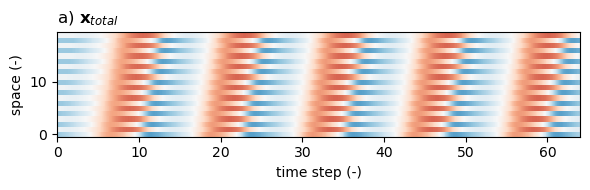

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True, sharey=True)

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
    "rasterized": True,
}

# Original data
# ax = axes[0]
ax.pcolor(time, space_dim, data_original, **pcolor_kwargs)
ax.set_title(r"a) $\mathbf{x}_{total}$", loc="left")
ax.set_ylabel("space (-)")
ax.set_xlabel("time step (-)")

# ax = axes[1]
# ax.pcolor(time, space_dim, slow_modes.T, **pcolor_kwargs)
# ax.set_title(r"b) $\mathbf{x}_{slow}$", loc="left")
# ax.set_ylabel("space (-)")

# ax = axes[2]
# ax.pcolor(time, space_dim, fast_modes.T, **pcolor_kwargs)
# ax.set_title(r"c) $\mathbf{x}_{fast}$", loc="left")
# ax.set_ylabel("space (-)")

fig.tight_layout()
plt.show()

# SINDy-SHRED

Set random seed

In [6]:
# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Optional: CUDA-specific seed (only if using CUDA)
# if device == "cuda":
#     torch.cuda.manual_seed(0)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

We now select indices to divide the data into training, validation, and test sets.

## Specify data to fit

In [7]:
# Remove randomness for investigation by manually selecting 3 sensors (out of 20).
sensor_locations = np.array([5, 14, 7])
num_sensors = len(sensor_locations)

latent_dim = 2
poly_order = 3

lags = 120
train_length = 750 // 4
validate_length = 0
load_X = copy.deepcopy(data_original)

# Sub-sample for speed up
load_X = load_X.T[::4]
dt = dt_data * 4
lags = lags // 4
t_plot = time[::4]
t_len = n_time // 4

Text(0.5, 0, 'time step (-)')

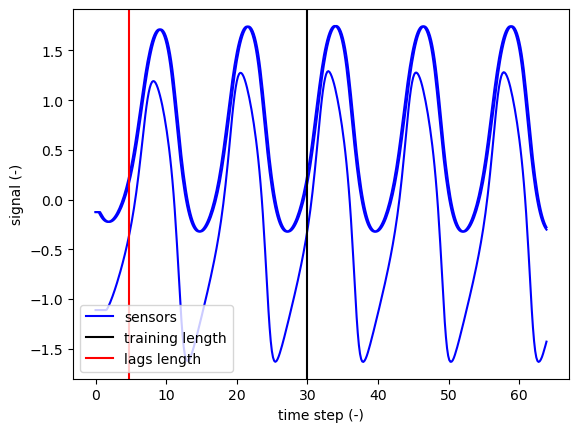

In [8]:
plt.plot(
    t_plot,
    load_X[:, sensor_locations],
    color="b",
    # label=["sensors", None, None, None, None, None],
    label=["sensors", None, None],
)
plt.gca().axvline(t_plot[train_length], color="k", label="training length")
plt.gca().axvline(t_plot[lags], color="r", label="lags length")

plt.legend()
plt.ylabel("signal (-)")
plt.xlabel("time step (-)")

The lags length should be picked to capture the dominant time dynamics of the system.

## Fit SINDy-SHRED

In [9]:
shred = sindy_shred.SINDyShred(
    latent_dim=latent_dim, poly_order=poly_order, verbose=True, num_epochs=600,
)
shred.fit(
    num_sensors, dt, load_X, lags, train_length, validate_length, sensor_locations
)

1 : tensor(0.3220, device='mps:0', grad_fn=<AddBackward0>)
2 : tensor(0.2176, device='mps:0', grad_fn=<AddBackward0>)
3 : tensor(0.2452, device='mps:0', grad_fn=<AddBackward0>)
4 : tensor(0.2552, device='mps:0', grad_fn=<AddBackward0>)
5 : tensor(0.2202, device='mps:0', grad_fn=<AddBackward0>)
6 : tensor(0.2032, device='mps:0', grad_fn=<AddBackward0>)
7 : tensor(0.2057, device='mps:0', grad_fn=<AddBackward0>)
8 : tensor(0.2003, device='mps:0', grad_fn=<AddBackward0>)
9 : tensor(0.1991, device='mps:0', grad_fn=<AddBackward0>)
10 : tensor(0.1999, device='mps:0', grad_fn=<AddBackward0>)
11 : tensor(0.2008, device='mps:0', grad_fn=<AddBackward0>)
12 : tensor(0.2057, device='mps:0', grad_fn=<AddBackward0>)
13 : tensor(0.2026, device='mps:0', grad_fn=<AddBackward0>)
14 : tensor(0.1951, device='mps:0', grad_fn=<AddBackward0>)
15 : tensor(0.1950, device='mps:0', grad_fn=<AddBackward0>)
16 : tensor(0.1948, device='mps:0', grad_fn=<AddBackward0>)
17 : tensor(0.1873, device='mps:0', grad_fn=<AddB

## Posthoc dynamics discovery

SINDy-derived dynamical equation:

(x0)' = -0.248 1 + 1.103 x0 + -1.167 x1 + 0.268 x0^2 + -0.055 x0 x1 + 0.098 x1^2 + -1.029 x0^3 + 1.378 x0^2 x1 + -1.024 x0 x1^2 + 0.467 x1^3
(x1)' = 0.007 1 + 0.495 x0 + -0.453 x1 + -0.125 x0^2 + 0.124 x0 x1 + -0.015 x1^2 + 0.114 x0^3 + 0.057 x0^2 x1 + -0.048 x0 x1^2 + 0.155 x1^3


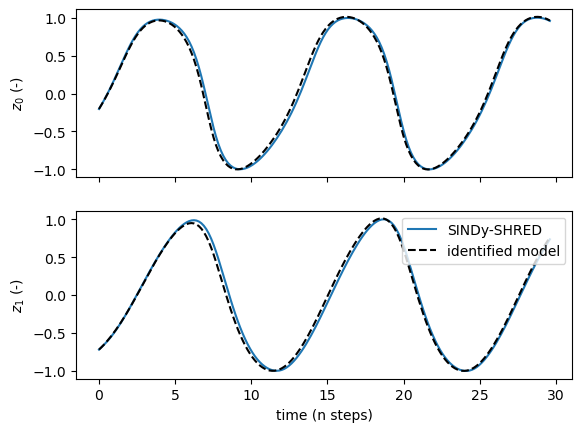

<Figure size 640x480 with 0 Axes>

In [10]:
shred.sindy_identify(
    # threshold=0.2,
    threshold=0.,
    plot_result=True,
)
plt.gcf().suptitle(f"latent space")
plt.gcf().tight_layout()

The actual equation is:
\begin{align}\label{eq:slow-mode}
    \dot{v}& = v - \frac{1}{3}v^3 - w + 0.65 \\
    \dot{w} &= \frac{1}{\tau_1}(v + 0.7 - 0.8w).
\end{align}

You can manually adjust the threshold to discover more or less sparse symbolic representations. The current value finds a nice comprimise between a good fit and a sparse representation.

Changing the sparsity threshold allows us to explore different symbolic representations of the system. We come close to recovering the true system, including the coefficients, however, there are some misreprsented terms. Reducing the sparsity recovers a better fit, but introduces a number of additional terms. Both cases result in SINDy-SHRED being able to recover a highly accurate model for the latent space.



### Demonstrate the sensor reconstruction

#### Train split

Here we reconstruct the test split using just the sensor time series demonstrating that the SDN recovers a robust mapping.

In [11]:
# The reconstruction should probably be a function.
train_recons = shred._scaler.inverse_transform(
    shred._shred(shred._train_data.X).detach().cpu().numpy()
)

train_ground_truth = shred._scaler.inverse_transform(
    shred._train_data.Y.detach().cpu().numpy()
)
print("Error in the sensor reconstruction of train split")
print(
    relative_error(train_recons, train_ground_truth)
)

Error in the sensor reconstruction of train split
0.073235005


#### Test split

Just to show that it works on the out of sample split.

In [12]:
# The reconstruction should probably be a function.
test_recons = shred._scaler.inverse_transform(
    shred._shred(shred._test_data.X).detach().cpu().numpy()
)

test_ground_truth = shred._scaler.inverse_transform(
    shred._test_data.Y.detach().cpu().numpy()
)
print("Error in the sensor reconstruction of test split")
print(
    relative_error(test_recons, test_ground_truth)
)

Error in the sensor reconstruction of test split
0.06697093


Text(0.5, 0, 'time step (-)')

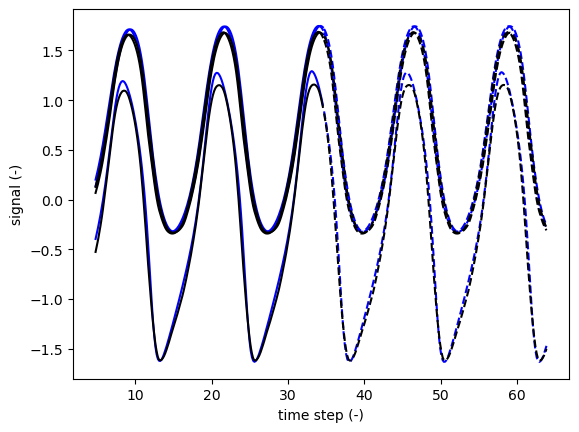

In [13]:
plt.plot(
    t_plot[lags:train_length + lags],
    train_ground_truth[:, sensor_locations],
    color="b",
)

plt.plot(
    t_plot[lags:train_length + lags],
    train_recons[:, sensor_locations],
    color="k",
)

plt.ylabel("signal (-)")
plt.xlabel("time step (-)")

plt.plot(
    t_plot[train_length + lags:],
    test_ground_truth[:, sensor_locations],
    color="b",
    ls='--'
)

plt.plot(
    t_plot[train_length + lags:],
    test_recons[:, sensor_locations],
    color="k",
    ls='--'
)

plt.ylabel("signal (-)")
plt.xlabel("time step (-)")

#### Prediction

In [14]:
# Predict the latent space...
x_predict = shred.sindy_predict(
    t=np.arange(0, shred._test_length * shred._dt - 2* shred._dt, shred._dt)
)
# Decode to the high-dimensional space...
physical_predict = shred.shred_decode(x_predict)
# And scale to the original data.
physical_predict = shred._scaler.inverse_transform(physical_predict)

Text(0.5, 0, 'time step (-)')

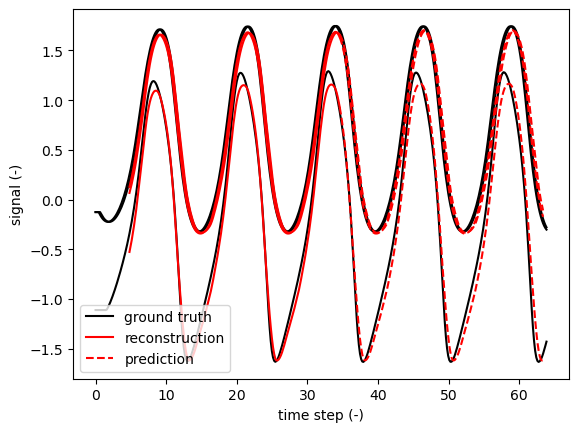

In [15]:
l = plt.plot(
    t_plot,
    load_X[:, sensor_locations],
    color="k",
)
l[0].set_label("ground truth")

l = plt.plot(
    t_plot[lags:train_length + lags],
    train_recons[:, sensor_locations],
    color="r",
)
l[0].set_label("reconstruction")

l = plt.plot(
    t_plot[train_length + lags - 1: - 3],
    physical_predict[:, sensor_locations],
    color="r",
    ls='--',
)
l[0].set_label("prediction")

plt.legend()
plt.ylabel("signal (-)")
plt.xlabel("time step (-)")

The gap at the beginning is from the lag used by the training. E.g., the latent space is the result of the time series for a lag prior.